# Baseline method

In this notebook we train a basic shallow neural network (SNN) to predict fatigue rates based on `10-min` stats of accelerations to serve as a baseline for the autoencoder method.

## Data loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config import settings
from src.data import datamodule as dm
from pathlib import Path
from src.model.transformation import (FromBuffer , 
                                      CutPSD, LogTransform , NormLayer , SqueezeLayer,
                                      UnsqueezeLayer)


import matplotlib.pyplot as plt
from torch import nn 
from src.data.utils import print_database_overview, load_all_from_db 


In [3]:
db_path = Path(settings.path.processed, 'norther.db')
assert db_path.exists(), f"Database not found at {db_path}"
print_database_overview(db_path)
meta_data = load_all_from_db(db_path, 'metadata')
frequency_axis = FromBuffer()(meta_data.loc[0,'frequency_axis'])

SQLite Database Overview
Table: processed_data - id, timestamp, turbine_name, Welch_X, Welch_Y, Welch_Z, RMS_X, RMS_Y, RMS_Z, RollingAverage_X, RollingAverage_Y, RollingAverage_Z, Range_X, Range_Y, Range_Z, Mean_X, Mean_Y, Mean_Z
Table: sqlite_sequence - name, seq
Table: metadata - frequency_axis, sample_rate, window_size, processing_method
Table: scada - timestamp, mean_windspeed, min_windspeed, max_windspeed, std_windspeed, mean_yaw, min_yaw, max_yaw, std_yaw, mean_power, min_power, max_power, std_power, mean_pitch, min_pitch, max_pitch, std_pitch, mean_rpm, min_rpm, max_rpm, std_rpm, mean_winddirection, min_winddirection, max_winddirection, std_winddirection, mean_NAC_ACC_Z, min_NAC_ACC_Z, max_NAC_ACC_Z, rms_NAC_ACC_Z, rms1p_NAC_ACC_Z, mean_NAC_ACC_FA, min_NAC_ACC_FA, max_NAC_ACC_FA, rms_NAC_ACC_FA, rms1p_NAC_ACC_FA, mean_NAC_ACC_SS, min_NAC_ACC_SS, max_NAC_ACC_SS, rms_NAC_ACC_SS, rms1p_NAC_ACC_SS, mean_ti, pred_Mtn_legacy, relative_wind_dir, pred_Mtn_dnn, Mean_muY, CoV, std_NAC_ACC

In [91]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# Collect fleet leaders
fleet_leader_list = ", ".join([f"'{t}'" for t in settings.norther.fleet_leader])

# Step 1: Fetch column metadata from the scada table
query_columns = "PRAGMA table_info(scada)"  # Retrieves metadata about the table
columns_info = pd.read_sql_query(query_columns, conn)

# Step 2: Filter columns containing 'NAC_ACC' (programmatic filtering in Python)
filtered_columns = columns_info[columns_info['name'].str.contains('NAC_ACC')]['name'].tolist()

# Step 3: Use the filtered columns in the SELECT clause dynamically
columns_str = ", ".join([f"s.{col}" for col in filtered_columns])  # Prepare column string for SQL

# Step 4: Construct the final query
query = f"""
SELECT 
    p.timestamp, 
    p.turbine_name, 
    {columns_str},
    s.DEM5_TP_SG_LAT014_Mtn
FROM 
    processed_data p
LEFT JOIN 
    scada s
ON 
    p.timestamp = s.timestamp 
    AND p.turbine_name = s.turbine_name
WHERE
    p.turbine_name IN ({fleet_leader_list})
"""

# Execute the query
merged_data = pd.read_sql_query(query, conn)
merged_data.dropna(how='all',axis=1,inplace=True)
merged_data.dropna(inplace=True)

## Training

In [48]:
training_turbines = settings.norther.fleet_leader[:2]

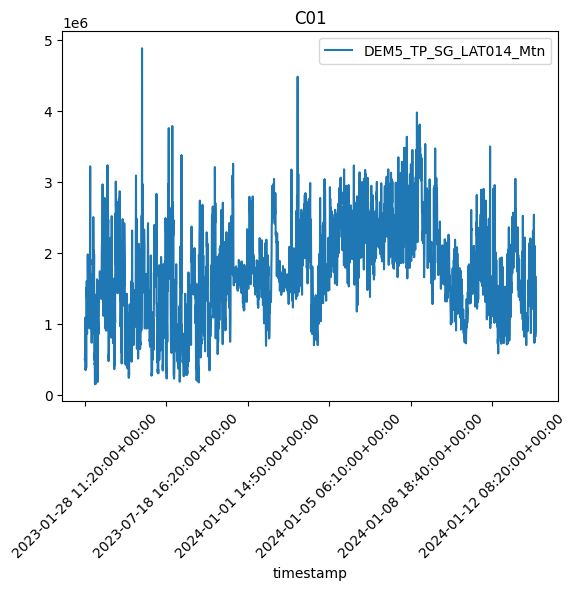

In [64]:
fig, ax = plt.subplots()
merged_data.query("turbine_name == 'NRTC01'").plot('timestamp','DEM5_TP_SG_LAT014_Mtn',ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title('C01')
plt.show()

In [111]:
from src.data import datamodule as dm
from src.model.transformation import ToTensor, EncoderBasedOnList
from src.model.prepared_queries import do_nothing

# Suppose your columns now include the PSDs *and* the target DEM
train_columns = list(merged_data.columns[1:])  # Columns to include in the query
train_transforms = [nn.Identity()] + 16 * [ToTensor()]

# Dynamically build the condition to exclude rows with NULLs
non_null_conditions = " AND ".join([f"{col} IS NOT NULL" for col in train_columns])

# Create the final query with the non-NULL condition
key_query = f"""
SELECT id 
FROM scada
WHERE turbine_name IN ('{"','".join(training_turbines)}')
  AND timestamp BETWEEN '{settings.norther.training_start}' AND '{settings.norther.training_end}'
  AND {non_null_conditions}
"""


data_loader_reg = dm.PSDDataModule(
    db_path=db_path,
    view_query=do_nothing,    # or any custom query that fetches Welch_*, DEM
    view_table_name='scada',
    key_query=key_query,
    key_name='id',
    columns=train_columns,
    transform_func=train_transforms,
    batch_size=248,
    cached=True,
    return_dict=True
)

data_loader_reg.setup()

Exception ignored in: <function PSDDataset.__del__ at 0x7a132e3d4dc0>
Traceback (most recent call last):
  File "/home/owilab/Documents/YacineB/Code/damage_prediction_AE/src/data/datamodule.py", line 150, in __del__
    self.conn.close()
AttributeError: 'PSDDataset' object has no attribute 'conn'
Exception ignored in: <function PSDDataset.__del__ at 0x7a132e3d4dc0>
Traceback (most recent call last):
  File "/home/owilab/Documents/YacineB/Code/damage_prediction_AE/src/data/datamodule.py", line 150, in __del__
    self.conn.close()
AttributeError: 'PSDDataset' object has no attribute 'conn'


In [114]:
for batch in data_loader_reg.train_dataloader():
    print(batch.keys())
    break

dict_keys(['turbine_name', 'mean_NAC_ACC_Z', 'min_NAC_ACC_Z', 'max_NAC_ACC_Z', 'rms_NAC_ACC_Z', 'rms1p_NAC_ACC_Z', 'mean_NAC_ACC_FA', 'min_NAC_ACC_FA', 'max_NAC_ACC_FA', 'rms_NAC_ACC_FA', 'rms1p_NAC_ACC_FA', 'mean_NAC_ACC_SS', 'min_NAC_ACC_SS', 'max_NAC_ACC_SS', 'rms_NAC_ACC_SS', 'rms1p_NAC_ACC_SS', 'DEM5_TP_SG_LAT014_Mtn'])
